In [2]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import colorsys
import sys
import time
from IPython import display
# import tensorflow as tf
# from tensorflow.keras.datasets import mnist



# Neural Networks - The Perceptron

## Introduction

Neural networks are excellent examples of (often non-linear) function optimization.

Even though real neurons look like this:

![Real Neuron](https://static.turbosquid.com/Preview/2014/12/03__09_02_06/all.jpg5254a144-6d9d-4a4f-b9b0-6fcbba4f64bcOriginal.jpg)

and have highly complicated biochemical processes that control their firing given input in the many dendrites, people have long thought about how to approximate their function mathematically.



### The artificial neuron

We will briefly review some "proper" Nobel-prize-winning equations in the later part of the course, when we talk about partial derivative equations - however, as you may imagine, a real neuron's complexity is rather daunting, so for simulations, simpler models would be good as a start.

Here's an extremely simplified model - a so-called artificial neuron which simply
1. takes several inputs $x_i$
2. sums them up as $\sum x_i$
3. pushes them through an activation function $f(\sum x_i)$ and
4. delivers one output $y=f(\sum x_i)$ to downstream neurons.

![Simplified neuron and model](https://cdn-images-1.medium.com/max/1200/1*SJPacPhP4KDEB1AdhOFy_Q.png)

This model is based on the ground-breaking modeling work outlined in the paper by McCullough and Pitts from 1943. In this work, they used a step-function as $f$.

McCulloch, W. and Pitts, W. (1943). A logical calculus of the ideas immanent in nervous activity. Bulletin of Mathematical Biophysics, 5:115–133.

### Activation functions

The purpose of the activation function is to introduce more complicated processing of the inputs - we will talk about this more later. The most common choices are plotted below:

In [3]:
def activation(x,type_ = 'tanh'):
    if type_=='tanh':
        out = np.tanh(x)
    else:
        if 'logistic' == type_:
            out = 1.0 / (1 + np.exp(-x))
        else:
            if 'relu' == type_:
                out = np.maximum(np.zeros_like(x), x)
            else:
                if 'perceptron' == type_:
                    # out = np.where(x > 0, 1, 0)
                    out = x >= 0
                else:
                    if 'linear' == type_:
                        out = x
                    else:
                        if 'softmax' == type_:
                            # out = np.exp(x - np.max(x)) / np.sum(np.exp(x - np.max(x)))
                            out = np.log(1 + np.exp(x))
                        else:
                            raise Exception(np.array(['do not know type ',type_]))

    return out


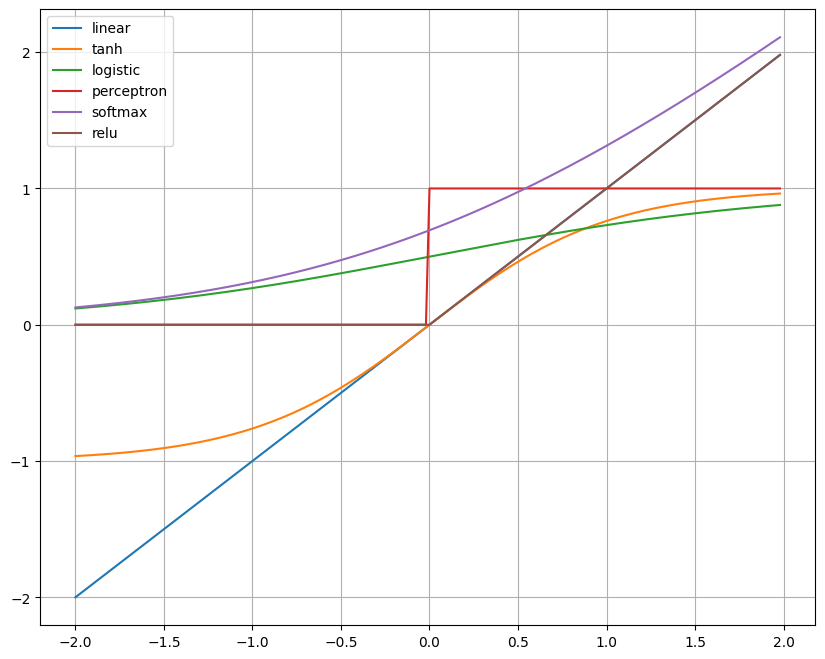

In [4]:
# x-values
x=np.arange(-2,2,0.02)

# activation functions
plt.figure(figsize=(10,8))
plt.plot(x,activation(x,'linear'),label='linear');
plt.plot(x,activation(x,'tanh'),label='tanh');
plt.plot(x,activation(x,'logistic'),label='logistic');
plt.plot(x,activation(x,'perceptron'),label='perceptron');
plt.plot(x,activation(x,'softmax'),label='softmax');
plt.plot(x,activation(x,'relu'),label='relu');
plt.grid()
plt.legend()
plt.show()

Quick question: why does the "perceptron" line look a bit weird???

## Learning networks - the perceptron

Let's try to do something simple now. Let's assume that our data we would like to learn consists of pairs $\vec{x}_i,y_i$, and that the $y_i$ can only take on **two values** ($y_i=\{-1,1\}$).

Furthermore, we assume that the data has a **linear structure**. We can quantify this like so:

There exists some $\vec{w}^* \in \mathbb{R}^d$, such that $\|\vec{w}^*\|=1$  and for
some $\alpha > 0$, for all $i$ $\in {1, 2, \dots , n}$
it holds that:

$$
y_i(\vec{w}^* \vec{x_i}) > \alpha
$$

Which, when you remember that $y_i=-1,1$, simply says that the sign of $(\vec{w}^*\vec{x}_i)$ is the same as the corresponding $y_i$.

The constant $\alpha$ is introduced as a lower bound on the value of $y_i(\vec{w}^*\vec{x}_i)$.

Note, that if you find such a vector $\vec{w}^*$, then all points that satisify

$$
(\vec{w}^* \vec{x_i}) = 0
$$

define a line (through the origin - if we augment our x-s with a leading "1" and add another leading $w_0$ to $\vec{w}$, then we can also model the intercept or bias of that line)!


Finally, we will assume that all input values $\vec{x}_i$ are bounded from above (so the maximum distance from the origin for these points is some number $D$, such that for all $i$, $\|\vec{x}_i\|<D$. We will need this later.

Note, that the condition shown above means that points that are misclassified can be found like this:

$$
y_i(\vec{w}^* \vec{x_i}) <= 0
$$

and again, in order to find the ideal conditions, our weight vector defines a hyper-plane like so:

$$
y_i(\vec{w}^* \vec{x_i}) > 0
$$


Note also, that this is equivalent to a **point-wise** cost or loss (i.e., a loss that must be valid at each point) of, given any particular weight vector $\vec{w}$:

$$
l_i(\vec{w})=\max{\left( 0,y_i(\vec{w}\vec{x}_i) \right )}
$$

<div class="alert alert-warning">
<p>
this expression for each point is always non-negative, as it is exactly zero if the point is classified correctly, and positive if it is classified incorrectly due to the minus sign
</p>
</div>
    
Written like this, the loss at each point is actually a rectified linear function (ReLU). Since the loss at each point is non-negative, if we want to optimize it for all data-points we have, we could simply minimize the average loss across all datapoints like so:

$$
l(\vec{w}) = \frac{1}{n}\sum_i^n l_i(\vec{w})=\frac{1}{n}\sum_i^n \max{\left( 0,y_i(\vec{w}\vec{x}_i) \right )}
$$


Note that due to the max-function inside the loss, this is a loss function that is convex (it is the sum of many point-wise convex functions), and it is has a single (discontinuous) deriviative for each input dimension. In addition, when we take a look at this loss, we can clearly see that it has a trivial solution at $\vec{w}^{(*)}=\vec{0}$, which is something that we will need to avoid.

### Quick inset: optimization of discontinuous loss functions
As we've discussed, loss functions such as shown above may not be ideal for optimization. In the case of the ReLU-function, this means that it is a sub-differentiable function as it has **two** part derivatives:

$$
\frac{d}{dx}\max{(0,x)}=
\begin{cases}
0  (x \lt 0) \\
1  (x \gt 0)
\end{cases}
$$

and now we have to choose, which value to take for this derivative at $x=0$. In most cases, libraries make the choice to set this value also to 0, such that the fully-defined derivative becomes:

$$
\frac{d}{dx}\max{(0,x)}=
\begin{cases}
0  (x \leq 0) \\
1  (x \gt 0)
\end{cases}
$$

For the **really** interested folks, this choice has actually an impact on optimization - see https://hal.archives-ouvertes.fr/hal-03265059v2/document


One way to get around this problem is to approximate the loss function in question with another function that possesses more desirable optimization properties.

In the case of the ReLU-function shown above, we can use the so-called softmax loss, which is an approximation to the max-function and is defined as:

$$
\text{soft}\left( s_0,s_1,s_2,...,s_{n-1}\right)=\log{\left( e^{s_0},e^{s_1},e^{s_2},...,e^{s_{n-1}}\right)}\approx \max{\left( s_0,s_1,s_2,...,s_{n-1}\right)}
$$

For $n=2$, and our loss-function above, this would be:

$$
\text{soft}\left( 0,s \right) = \log(1+s)
$$

This looks approximately similar to the ReLU-function as repeated here.

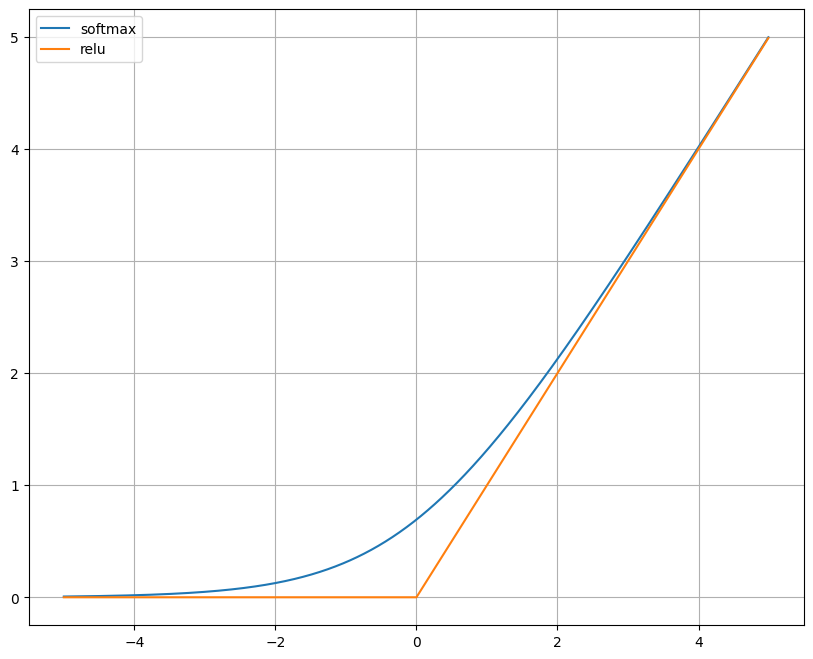

In [5]:
# x-values

x=np.arange(-5,5,0.01)

# activation functions
plt.figure(figsize=(10,8))
plt.plot(x,activation(x,'softmax'),label='softmax');
plt.plot(x,activation(x,'relu'),label='relu');
plt.grid()
plt.legend()
plt.show()

And this function is also convex, but infinitely differentiable and hence "easier" to optimize with traditional tools.

For the keen machine learners, the softmax function as defined here together with the resulting loss for a two-class problem is nothing more than the famous **logistic regression**, a rather unfortunately-named classification algorithm that maximizes a linear boundary between two classes as well!

### Perceptron learning rule

Let's go back to the good old perceptron though. We have our loss function and an idea what the optimal decision hyperplane should look like.

So, how do we update the weights now?

Let's write the algorithm created by Frank Rosenblatt in pseudo-code:

<div class="alert alert-warning">
set weights $\vec{w}= \vec{0}$

while any $y_i(\vec{w}\cdot\vec{x}_i)< 0$:

&nbsp;&nbsp;&nbsp;choose one index $k$, for which $y_k(\vec{w}\cdot\vec{x}_k)\leq 0$

&nbsp;&nbsp;&nbsp;set weights to $\vec{w} = \vec{w} + y_k\vec{x}_k$

</div>

Let's write down the algorithm in Python - this is much longer than the pseudocode above, but only because of the plotting of the updated decision hyperplane that happens during the execution:

In [6]:
def myPerceptron(x,y,maxIter,doPlot=True,xs=[],waittime=2,verbose=False):

    # init weights
    w = np.zeros((x.shape[1], 1)) * 0.01

    # check wrong outputs
    outputs = y * np.dot(x, w) <= 0

    # iteration counter
    ite=1

    # as long as there any misclassified points
    # and we are within iteration limits, do:
    while((np.sum(outputs)>0) & (ite<=maxIter)):
        # get all misclassified points
        ind=np.where(outputs>0)[0]

        # determine weight update from the first misclassified point [better to do randomly]
        update = y[ind[0]] * x[ind[0],:]

        # update all weights
        w += update[:,None]

        # increase iteration counter
        ite=ite+1

        # and determine the new classification output
        outputs = y*np.dot(x,w) <=0

        # update plots with new decision hyperplane prediction
        # do lots of online plotting
        if (doPlot):
            display.clear_output(wait=True)
            if len(xs)==0:
                xs=np.arange(-10,10,0.2)
            # plot data and initial guess
            plt.ion()
            # plot the line from the weights
            ys=(-w[1] * xs - w[0]) / w[2]
            figure, ax = plt.subplots(figsize=(10,8))
            # get positive and negative examples
            indPos = y==1
            indNeg = y==-1
            # scatter them
            ax.scatter(x[indPos.ravel(),1],x[indPos.ravel(),2])
            ax.scatter(x[indNeg.ravel(),1],x[indNeg.ravel(),2])
            plot1, = ax.plot(xs, ys,'b-')
            # do proper axis limits
            plt.xlim((xs[0],xs[-1]))
            plt.ylim((xs[0],xs[-1]))
            plt.title('Iteration {}: {} wrong (weights {}, {}, {})\n'.format(ite,np.sum(outputs),w[0],w[1],w[2]))
            plt.grid()
            plt.show()
            time.sleep(waittime)
        else:
            if verbose:
                print('Iteration {}: {} wrong (weight 0 = {})'.format(ite,np.sum(outputs),w[0]))
    print('Iteration {}: {} wrong (weight 0 = {})'.format(ite,np.sum(outputs),w[0]))
    return(w)

Let's test this algorithm with two reasonably well-separated point clouds in two dimensions:

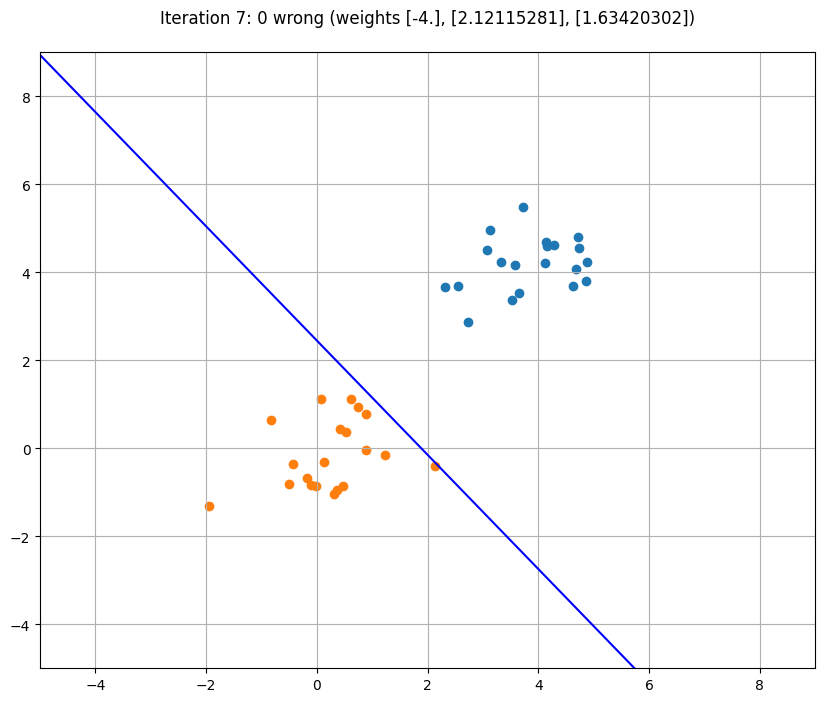

Iteration 7: 0 wrong (weight 0 = [-4.])


In [7]:
%matplotlib inline
rng = np.random.default_rng(seed=42)
x = np.vstack((rng.standard_normal((20,2)),rng.standard_normal((20,2))+4))
y = np.vstack((-1*np.ones((20,1)),np.ones((20,1))))
x = np.hstack((np.ones((x.shape[0],1)),x))

w = myPerceptron(x,y,50,True,np.arange(-5,10))


And we can see how the algorithm adjusts the line so that it tries to better capture the distribution of the data.

The perceptron algorithm like this has two important properties:

<div class="alert: alert-warning">
<p> ...

<p> ...
</div>

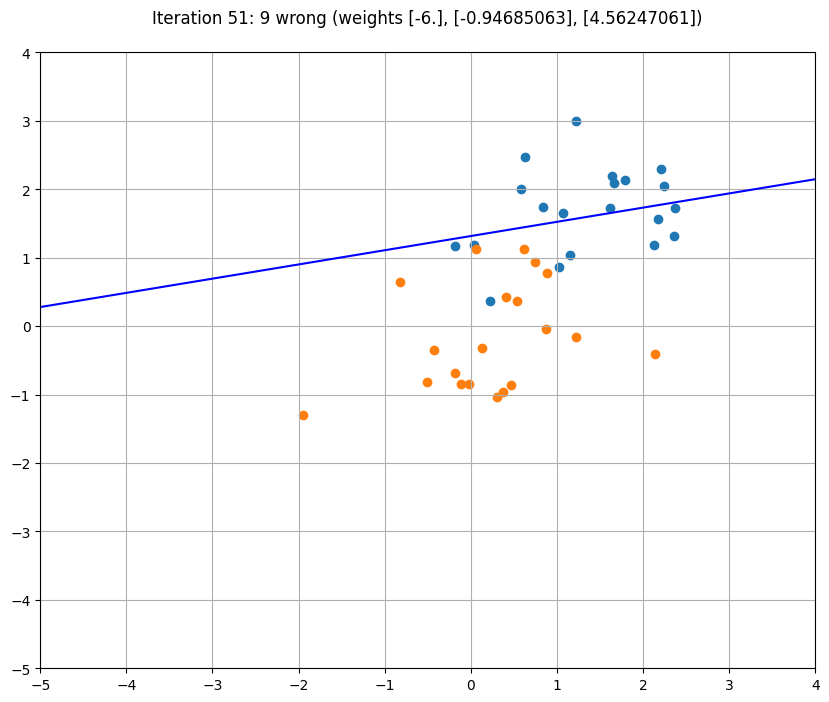

Iteration 51: 9 wrong (weight 0 = [-6.])


In [8]:
rng = np.random.default_rng(seed=42)
x = np.vstack((rng.standard_normal((20,2)),rng.standard_normal((20,2))+1.5))
y = np.vstack((-1*np.ones((20,1)),np.ones((20,1))))
x = np.hstack((np.ones((x.shape[0],1)),x))

w = myPerceptron(x,y,50,True,np.arange(-5,5),0.2)


Hence, we can see that the algorithm (by definition) will not stop as it is not possible to find a line that splits the data.

In this case, you will have to settle for the last decision-plane that the algorithm finds!!

We do note, however, that the perceptron algorithm will - over time - converge to the "best" hyperplane splitting the classes, where "best" will need to be defined in more detail.

### Proof of convergence for perceptrons

How can we prove that this algorithm does its job?

We can see that if it finishes, the line will separate the classes. So, what we need to prove is that the algorithm converges in a limited amount of steps $k$.

In detail: Assume that there exists some parameter vector $\vec{w}^*$ such that $||\vec{w}^*||=1$, and some $\alpha > 0$ such that for all k = 1...n, $y_k(\vec{x}\cdot\vec{w}^*) \geq \alpha$.

The latter comes as we formulate the correct classifications for the Perceptron!

#### Lower bound

Let's try to find a lower bound for $k$ first. Let's take a misclassified point $i$ and update it:

$$
\vec{w}_{k+1}=\vec{w}_k+y_i\vec{x}_i
$$

we can multiply this by $\vec{w}^*$ to get

$$
\vec{w}_{k+1}\vec{w}^*=\vec{w}_k\vec{w}^*+y_i\vec{x}_i\vec{w}^*
$$

but we required that the second term on the right - if we find a solution - is $>\alpha$, so:

$$
\vec{w}_{k+1}\vec{w}^*>\vec{w}_k\vec{w}^*+\alpha
$$

Now, let's start the process with $\vec{w}_0=\vec{0}$, which is our initialization of the weights. This means the update becomes:

$$
\vec{w}_{1}\vec{w}^*>\alpha
$$

So, if we just did this $k$ times we therefore get:

$$
\vec{w}_{k+1}\vec{w}^*>k\alpha
$$

And since $\|\vec{w}_{k+1}\|\|\vec{w}^*\|>\vec{w}_{k+1}\vec{w}^*$, we get:

$$
\|\vec{w}_{k+1}\|>k\alpha
$$


#### Upper bound

For the upper bound, let's write the norm of the update step:

$$
\|\vec{w}_{k+1}\|^2=\|\vec{w}_k+y_i\vec{x}_i\|^2=\|\vec{w}_k\|^2+2y_i\vec{w}_k\vec{x}_i+\|\vec{x}_i\|^2<\|\vec{w}_k\|^2+\|\vec{x}_i\|^2
$$

where we've used the fact that the $|y_i|=1$. But we required bounded points: $\|\vec{x}_i\|<D$, so:

$$
\|\vec{w}_{k+1}\|^2<\|\vec{w}_k\|^2+D^2
$$

Again, we start with $\vec{w}_0=\vec{0}$, so we get:

$$
\|\vec{w}_{1}\|^2<D^2
$$

and doing that $k$ times, we get:

$$
\|\vec{w}_{k+1}\|^2<kD^2
$$


#### Putting it together
Now, we've got two results - an upper and a lower bound:

$$
k^2{\alpha}^2<\|\vec{w}_{k+1}\|^2<kD^2
$$

so we "ignore" the middle term and get:

$$
k<\frac{D^2}{{\alpha}^2}
$$

What that means is that the algorithm is **guaranteed** to converge in a maximum number of steps, provided the data is linearly separable (related to the constant $\alpha$) and that it is bounded (related to the constant $D$).

### Logical functions with a perceptron

The original paper by McCulloch and Pitts talked about using the neuronal model as a substitute for **logical** operations. So, let's try to follow their reasoning.

Let's say I want to build a neuron that receives two inputs $x_1,x_2$ - these inputs are logical values, true or false. I want the neuron to run a simple logical operation, so that, for example, its output $y$ will be equal to a target function, such as $t = x_1 \text{ AND } x_2$.

We can see that $t$ is a function with exactly two possible values as well. Given that the original perceptron was formulated as a two-class learner, this means we can try to apply this here as well!

In [9]:
# create our world of values
inputA=np.array([[0],[0],[1],[1]])
inputB=np.array([[0],[1],[0],[1]])

# create our intended targets using the logical function
targetLogical= inputA & inputB

# switch to classes +1 , -1 [instead of 1,0]
targetLogical[targetLogical==0]=-1

print(targetLogical)

[[-1]
 [-1]
 [-1]
 [ 1]]


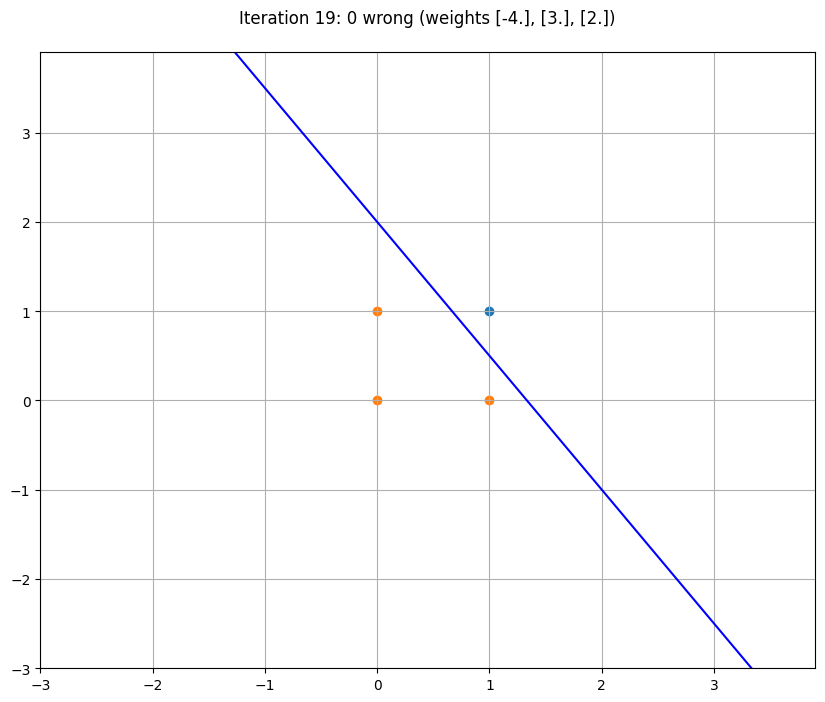

Iteration 19: 0 wrong (weight 0 = [-4.])


array([[-4.],
       [ 3.],
       [ 2.]])

In [10]:
# don't forget the bias
x = np.hstack((np.ones((4,1)),inputA,inputB))

myPerceptron(x,targetLogical,20,True,np.arange(-3,4,0.1),0.5)

So AND works.

In [11]:
targetLogical= inputA | inputB
targetLogical[targetLogical==0]=-1
print(targetLogical)

[[-1]
 [ 1]
 [ 1]
 [ 1]]


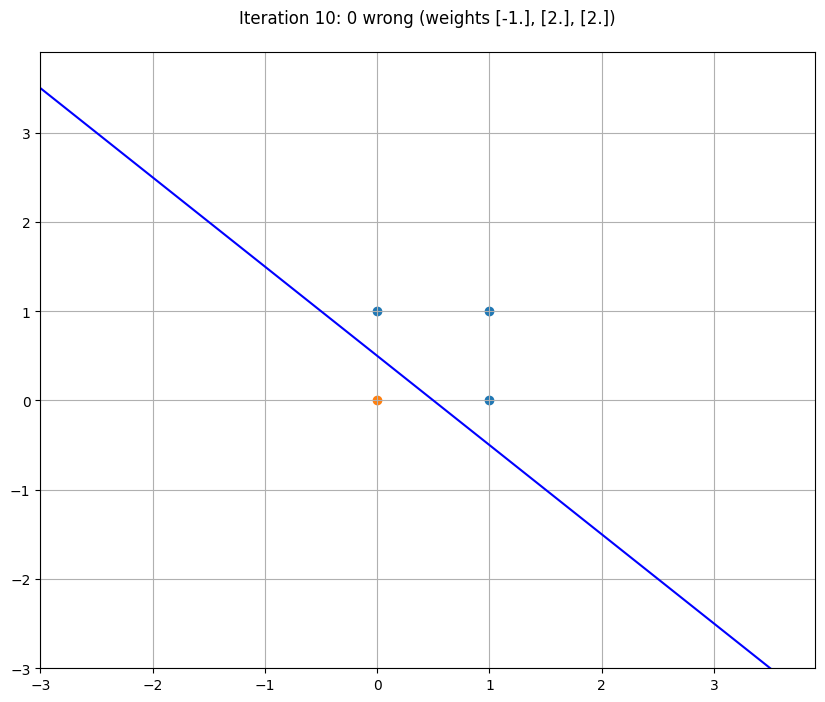

Iteration 10: 0 wrong (weight 0 = [-1.])


array([[-1.],
       [ 2.],
       [ 2.]])

In [12]:
x = np.hstack((np.ones((4,1)),inputA,inputB))

myPerceptron(x,targetLogical,20,True,np.arange(-3,4,0.1),0.5)

So OR works

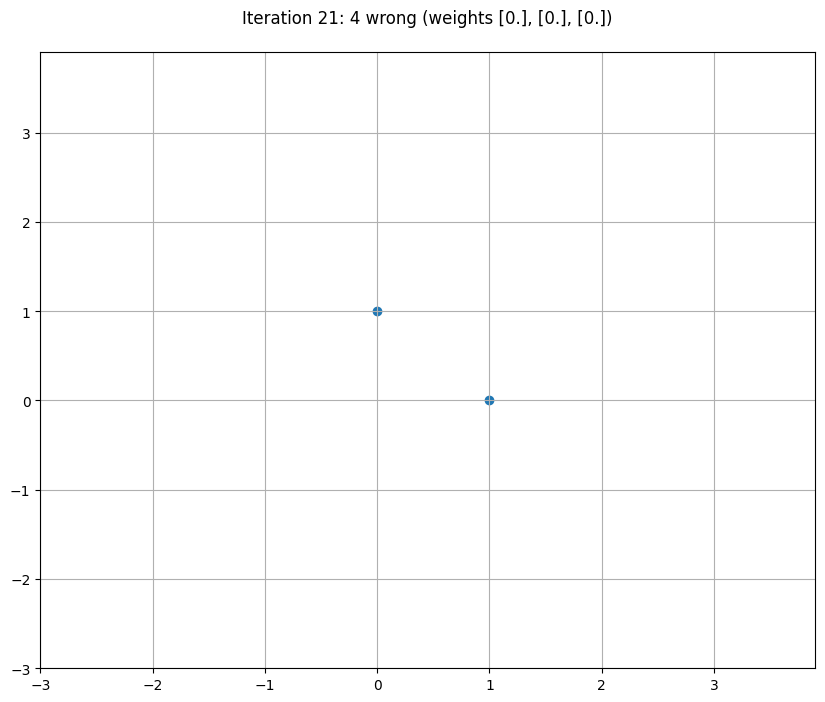

Iteration 21: 4 wrong (weight 0 = [0.])


array([[0.],
       [0.],
       [0.]])

In [13]:
# let's try the "infamous" XOR
targetLogical= inputA ^ inputB
x = np.hstack((np.ones((4,1)),inputA,inputB))

myPerceptron(x,targetLogical,20,True,np.arange(-3,4,0.1),0.5)

But, XOR does not work. We can see why since it cannot be linearly separated.

The fact that such a simple logical function could not be processed by the perceptron was known for a long time.

However, given that you can get all possible values of two logical inputs with a suitable **chain** of AND and NOT (or with OR and NOT) operations, you can see that implementing this function would be possible if you simply string enough perceptrons together!

1969 saw the publication of a book "Perceptrons" by Marvin Minsky and Seymour Papert. Often it is said that the XOR problem was popularized by this book, which attributed to a dramatic decline in the popularity of neural networks - the first so-called AI winter. This is, however, only partly true since the result for XOR only holds for ONE SINGLE perceptron (again, a network of perceptrons would be fully capable of doing an XOR operation) - what Minsky and Papert showed, instead, is some limitations about those networks of perceptrons that related mostly to their EFFICIENCY, and not to the fact that they cannot in principle compute something.

Regardless, the first AI winter did happen and funding for neural network based research did decline dramatically.

### Multi-layer perceptrons

It was already mentioned above that it should be possible to put multiple perceptron units together to create an actual neural **network**.

We will talk about this in the next lecture, when we derive a more general way to train neurons and neural networks.



## Perceptrons for Digit Recognition

Let's apply the perceptrons to a "real-world" problem. We are going to use a digit dataset of 10000 digits from 0 to 9 that is shipped with the Matlab Deep Learning Toolbox.

Since our perceptrons for now can only handle two classes, let's arbitrarily decide to learn to recognize "0" and "1".

In [14]:
# you need to pip or conda this package first
# see https://pypi.org/project/python-mnist/

# import tensorflow_datasets as tfds
# import numpy as np

# # Load the MNIST dataset using tensorflow_datasets
# (ds_train, ds_test), ds_info = tfds.load(
#     'mnist',
#     split=['train', 'test'],
#     shuffle_files=True,
#     as_supervised=True,
#     with_info=True
# )

# home = expanduser("~")+'/repos/KU_NN/2023020923_2023020928_A2/data'
mndata = mnist.load_data()

# also we want it to load the gzipped files
mndata.gz = True

# let's load the train and test data files
xtrain, ytrain = mndata.load_training()
xtest, ytest = mndata.load_testing()

# we need these as floats, as integer operations will
# lead to problems in our perceptron updating!
xtrain = np.array(xtrain,dtype=float)
ytrain = np.array(ytrain,dtype=float)
xtest = np.array(xtest,dtype=float)
ytest = np.array(ytest,dtype=float)

print('Train:',xtrain.shape,ytrain.shape)
print('Test:',xtest.shape,ytest.shape)

# let's select only TWO classes from MNIST, as our
# perceptron so far can only handle two classes
indstrain = 0
indstest = 1

# get the data and normalize
xtrain_red = xtrain[indstrain,:]/255
ytrain_red = ytrain[indstrain]
xtest_red = xtest[indstest,:]/255
ytest_red = ytest[indstest]

# don't forget that we need +1/-1 as class labels
ytrain_red[ytrain_red==0] = -1
ytest_red[ytest_red==0] = -1
ytrain_red[ytrain_red==1] = 1
ytest_red[ytest_red==1] = 1

# check how much data we have now
print('Train reduced:',xtrain_red.shape,ytrain_red.shape)
print('Test reduced:',xtest_red.shape,ytest_red.shape)

NameError: name 'mnist' is not defined

In [ ]:
# plot a few random examples
fig = plt.figure(figsize=(12, 12))
columns = 4
rows = 4
indices = np.random.choice(np.arange(len(ytrain_red)),columns*rows,False)
for i in range(1, columns*rows +1):
    img = xtrain_red[indices[i - 1]].reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title('Label {}'.format(ytrain_red[indices[i-1]]))
plt.show()

In [19]:
# don't forget to add the biases to our data
xtrain_ = np.hstack((np.ones((xtrain_red.shape[0],1)),xtrain_red))
ytrain_ = ytrain_red
xtest_ = np.hstack((np.ones((xtest_red.shape[0],1)),xtest_red))
ytest_ = ytest_red
print(xtrain_.shape,xtest_.shape)

NameError: name 'xtrain_red' is not defined

In [20]:
def myPerceptron_digits(xtrain,ytrain,xtest,ytest,maxIter,shuffle=True):

    # init weights
    w = np.zeros((xtrain.shape[1],1))+0.01

    # check wrong outputs on train
    trainerrors = np.array([])

    # do the dot products - I am doing these manually here, but there
    # are convenience functions available in scipy that could handle
    # row dot products like the one I need here
    tmp = np.array([])
    for row1 in xtrain:
        tmp = np.append(tmp, np.dot(row1, w))

    # check the errors on the training dataset
    trainoutputs = (ytrain * tmp) <= 0
    # check the error rate
    trainerrors = np.append(trainerrors,np.sum(trainoutputs)/len(ytrain)*100)

    # check errors on test dataset
    testerrors = np.array([])
    tmp = np.array([])
    for row1 in xtest:
        tmp = np.append(tmp, np.dot(row1, w))
    testoutputs = ...
    testerrors = np.append(testerrors,np.sum(testoutputs)/len(ytest)*100)


    ite=1

    # as long as there any misclassified points
    # and we are within iteration limits, do:
    while((np.sum(trainoutputs)>0) & (ite<=maxIter)):
        # get all misclassified points
        inds = np.where(train_outputs)[0]

        # now let's try to also add random points
        if shuffle:
            ind = np.random.choice(misclassified_indices)
        else:
            ind = inds[0]

        # update the weights with one misclassified point
        update = ytrain[ind] * xtrain[ind, :].reshape((-1, 1))
        w = update

        ite=ite+1

        # check the errors on the training dataset
        tmp = np.array([])
        for row1 in xtrain:
            tmp = np.append(tmp, np.dot(row1, w))
        trainoutputs = (ytrain * tmp) <= 0
        train_error_rate = np.sum(trainoutputs) / len(ytrain) * 100
        trainerrors = np.append(trainerrors,np.append(trainerrors, train_error_rate))

        # check errors on test dataset
        tmp = np.array([])
        for row1 in xtest:
            tmp = np.append(tmp, np.dot(row1, w))
        testoutputs = (ytest * tmp) <= 0
        test_error_rate = np.sum(testoutputs) / len(ytest) * 100
        testerrors = np.append(testerrors, test_error_rate)

        print('Iteration {}: train {:.2f} wrong, test {:.2f} wrong (weight 0 = {})'.format(ite,
                                                                                   trainerrors[-1],
                                                                                   testerrors[-1],w[0]))
    return(w,trainerrors,testerrors)

In [21]:
w,trainerrors,testerrors = myPerceptron_digits(xtrain_,ytrain_,xtest_,ytest_,1000)

NameError: name 'xtrain_' is not defined

As we can see the iteration wobbles around a bit, but converges to 100% accuracy within a hundred-something iterations.

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(trainerrors,label='Train')
plt.plot(testerrors,label='Test')

plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()
plt.show()


plt.figure(figsize=(10,10))
plt.scatter(trainerrors,testerrors)

plt.xlabel('Train')
plt.ylabel('Test')
plt.title('Correlation = {}'.format(np.corrcoef(trainerrors,testerrors)[1,0]))
plt.grid()
plt.show()



The visualization of the weights is also interesting now, as these encode the orthogonal direction of the decision plane in the 784-dimensional space along which the patterns of 0s and 1s can be separated!

In [ ]:
plt.figure(figsize=(10,10))
# visualize the weights reshaped into an image [minus the bias weight]
weight_image = w[1:].reshape((28, 28))
plt.imshow(weight_image, cmap='gray')

plt.title('Weight visualization')
plt.colorbar()
plt.show()

Depending on the iteration we did, we do get 0 errors on the training set, but sometimes a few errors remain on the test set.

This is the pre-cursor to a fundamental, incredibly important insight that holds for everything in learning and that is related to the function fitting discussion from earlier lectures:

<div class="alert alert-warning">
<p>...
</div>

## Multi-class extension

In the previous cases, we have always only looked at two classes. In fact, our life was made much easier by the particular choice of label values of $y={-1,1}$ as this allowed us to formulate our particular optimal separating hyperplane for the perceptron in one easy equation.

But what happens if we have multiple classes? The MNIST example above obviously has 10 classes, each corresponding to one digit.

Formally, we can define a multiclass dataset $\left\{ \left(\mathbf{x}_{i,}\,y_{i}\right)\right\} _{i=1}^{n}$
consisting of $C$ distinct classes of data given appropriate labels $y_i$. To make our lives easier, we can define the $C$ different values for the targets or labels to simply be their class index: $y_{p}\in\left\{ 0,1,...,C-1\right\}$.

One particularly simple idea for multi-class training is then to say that we reduce our problem to a set of two-class problems, for which we of course know how to treat it.

One solution will be to learn $C$ classifiers, each of which distinguishes one class $c$ from the other $C-1$ classes.

This means that we will need to create temporary labels for each classifier training, such that

$$
 \hat y_i = \begin{cases}   +1 \,\,\,\,\,\,\text{if}\,\, y_i = c \\ -1 \,\,\,\,\,\,\text{if}\,\, y_i \neq c    \end{cases}
$$

Each of these new problems can be trivially solved with our perceptron, yielding $C$ classifiers and $C$ linear decision hyperplanes.

The tricky question we are faced with is now, how do we assign labels to points? For this, let's turn to a three-class problem for illustration.

### Example: 3 classes

Let's imagine we have three classes like so:

In [ ]:
# this function will determine num_colors different
# hues in HSV space and return their RGB values
# note, this is a really fun problem if we include
# the perceptual optimization aspect of this issue ^^
def _get_colors(num_colors):
    colors=[]
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() * 10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

In [ ]:
# helper function that plots classes and boundaries if supplied
def plotClassesWithBoundary(x,y,w=[]):
    # class indices
    classes = np.sort(np.unique(y))
    # how many classes
    numc = len(classes)

    # get numc different colors for plotting
    colors = _get_colors(numc)

    # do we have boundaries - and if so, how many?
    if (len(w)>0):
        numw = len(w)/3
    else:
        numw=0

    # for plotting the boundaries
    xs = np.arange(np.min(x[:,0],axis=0),np.max(x[:,0],axis=0),0.1)
    plt.figure(figsize=(10,10))

    # loop through all classes
    for c in np.arange(0,numc):

        # get the indices of each class
        inds = y==classes[c]

        # scatter the data
        plt.scatter(x[:,0][inds.flatten()],x[:,1][inds.flatten()],color=colors[c])

        # if we have boundaries for each class, plot the corresponding class boundary
        if numw==numc:
            plt.plot(xs,(-(w[(c)*3+1]*xs)-w[(c)*3])/w[(c)*3+2],color=colors[c])

    # if only one boundary is supplied, plot this here
    if numw==1:
        plt.plot(xs,(-(w[1]*xs)-w[0])/w[2],color=colors[0])

    plt.grid()
    plt.show()


Let's create three classes of data

In [ ]:
rng = np.random.default_rng(seed=42)
x = np.vstack((rng.standard_normal((20,2)),
               rng.standard_normal((20,2))+5,
              rng.standard_normal((20,2))+np.array([5,-5])))
y = np.vstack((0*np.ones((20,1)),np.ones((20,1)),2*np.ones((20,1))))

Now let's create the new target labels for three two-class problems

In [ ]:
y1vs23 = ...
y2vs13 = ...
y3vs12 = ...


Plot the resulting classes and the two-class problems

In [ ]:
plotClassesWithBoundary(x,y)
plotClassesWithBoundary(x,y1vs23)
plotClassesWithBoundary(x,y2vs13)
plotClassesWithBoundary(x,y3vs12)

Now solve each of the two-class problems

In [ ]:
w1vs23 = myPerceptron(np.hstack((np.ones((x.shape[0],1)),x)),y1vs23,100,False)
w2vs13 = myPerceptron(np.hstack((np.ones((x.shape[0],1)),x)),y2vs13,100,False)
w3vs12 = myPerceptron(np.hstack((np.ones((x.shape[0],1)),x)),y3vs12,100,False)


That worked well - now let's plot the resulting classes and their boundaries separately

In [ ]:
plotClassesWithBoundary(x,y1vs23,w1vs23)
plotClassesWithBoundary(x,y2vs13,w2vs13)
plotClassesWithBoundary(x,y3vs12,w3vs12)

How does this look in a combined plot?

In [ ]:
plotClassesWithBoundary(x,y,np.vstack((w1vs23,w2vs13,w3vs12)))

So, now we have three class hyperplanes, and the question now becomes, how to assign a label to a point that is given to us. From looking at the above figure, we have three possible situations for a given point:

1) It is on the positive side of one classifier

2) It is on the positive side of more than one classifier

3) It is on the negative side of all classifiers


Given how we designed each sub-classification problem to be our usual two-class problem, we now realize that the class to be distinguished from the rest lies on the **positive side** of its classifier, and all the other points on the **negative side**.  For the $j^{th}$ classifier we have for the $i^{th}$ point $\vec{x}_i$:

$$
\vec{x}_{i}\cdot \vec{w}_j  \begin{cases}   > 0 \,\,\,\,\,\,\text{if}\,\,\, y_i = j  \\ < 0 \,\,\,\,\,\, \text{if} \,\,\, y_i \neq j.    \end{cases}
$$

So, for each of the existing points, the true label is simply given by the **...**:

$$
\vec{x}_{i}\cdot \vec{w}_j  = \underset{c \,=\, 0,...,C-1}...
$$

#### Case 1)

This, of course, will also make things easy for points of case 1), which lie on the positive side of only one classifier.

Hence, the label for these points is simply:

$$
y =  \underset{c \,=\, 0,...,C-1}{\text{argmax}} \,\,\,\vec{x}_{\,}\cdot \vec{w}_c
$$


#### Case 2)

In case the point falls on the positive side of two classifiers (remember, we only have a three class problem), we have to think.

...

This value is related to the **confidence** of the classifier!

How can we calculate the distance of a point to the line?

That is simply the evaluation normalized by the feature weight, that is:


$$
\text{signed distance of $\vec{x}_{i}$ to $j^{th}$ boundary} =  \frac{\vec{x}_{i}\cdot\vec{w}_j }{\left\Vert \vec{w}_{j} \right\Vert_2}
$$

So, if the feature weights become normalized, this reduces also to

$$
y =  \underset{c \,=\, 0,...,C-1}{\text{argmax}} \,\,\,\vec{x}_{\,}\cdot \vec{w}_c
$$

We now only need to worry about points that are equidistant to both class boundaries - in this case, we will assign a label at random. These points will provide the multi-class classification hyperplanes!

#### Case 3)

If the point is "inside" the negative regions of all classifiers, then all classifiers tell us that this point does **not** belong to them.

So, we turn the discussion in point 2) on its head and ask: which of the classifiers is **...** confident in this decision? Now, we need to measure the distance of this point in question to the **...** hyperplane.

Since each point here is on the negative side of all classifiers, all of the resulting signed distances are **...**. Therefore, the **...** is the **...**, as it corresponds to the smallest (in magnitude) negative number. Similarly, the largest distance in magnitude is the largest (in magnitude) negative number, and hence the smallest signed distance.

So, if the feature weights are still normalized, we again have:

$$
y =  \underset{c \,=\, 0,...,C-1}{\text{argmax}} \,\,\,\vec{x}_{\,}\cdot \vec{w}_c
$$

#### Putting everything together

We realize that all problems are solved by the exact same logic: assign the point to the label determined by the ... to all classifiers.


#### One versus All classifier (OvA)

When phrased like we did, the resulting classifier is called a **One versus All** classifier and the proper fusion rule for integrating multiple classifiers into one in this scheme is given by the maximum distances to the hyperplanes.


### Multi-class extension

What we did in the previous section was to do multi-class classification via several two-class classifiers. But this approach leads to problems.

Let's in particular look at this dataset:


In [ ]:
rng = np.random.default_rng(seed=42)
x = np.vstack((rng.standard_normal((20,2))+np.array([2,2]),
               rng.standard_normal((20,2))+np.array([2,-2]),
               rng.standard_normal((20,2))+np.array([-2,-2]),
               rng.standard_normal((20,2))/1.5
              ))
y = np.vstack((0*np.ones((20,1)),np.ones((20,1)),2*np.ones((20,1)),3*np.ones((20,1))))
plotClassesWithBoundary(x,y)

In [ ]:
y1vs234 = np.vstack((np.ones((20,1)),-1*np.ones((20,1)),-1*np.ones((20,1)),-1*np.ones((20,1))))
y2vs134 = np.vstack((-1*np.ones((20,1)),np.ones((20,1)),-1*np.ones((20,1)),-1*np.ones((20,1))))
y3vs124 = np.vstack((-1*np.ones((20,1)),-1*np.ones((20,1)),np.ones((20,1)),-1*np.ones((20,1))))
y4vs123 = np.vstack((-1*np.ones((20,1)),-1*np.ones((20,1)),-1*np.ones((20,1)),np.ones((20,1))))


In [ ]:
w1vs234 = myPerceptron(np.hstack((np.ones((x.shape[0],1)),x)),y1vs234,1000,False)
w2vs134 = myPerceptron(np.hstack((np.ones((x.shape[0],1)),x)),y2vs134,1000,False)
w3vs124 = myPerceptron(np.hstack((np.ones((x.shape[0],1)),x)),y3vs124,1000,False)
w4vs123 = myPerceptron(np.hstack((np.ones((x.shape[0],1)),x)),y4vs123,1000,False)

In [ ]:
plotClassesWithBoundary(x,y,np.vstack((w1vs234,w2vs134,w3vs124,w4vs123)))

In [ ]:
xt = np.hstack((np.ones((x.shape[0],1)),x))
for c in np.arange(1,5):
    labels = np.zeros((20,1))
    classoffset = (c-1)*20
    for p in np.arange(0,20):
        dist = np.zeros((4,1))
        dist[0] = np.dot(xt[classoffset+p,:],w1vs234)
        dist[1] = np.dot(xt[classoffset+p,:],w2vs134)
        dist[2] = np.dot(xt[classoffset+p,:],w3vs124)
        dist[3] = np.dot(xt[classoffset+p,:],w4vs123)
        labels[p] = np.argmax(dist)
    print(labels.flatten())

As we can see, the middle class is fully surrounded by datapoints of the other classes. So, since there are fewer datapoints for this class compared to the other three classes combined, the two-class problem to separate this class from the other classes will classify **all points as belonging to the non-middle class**.

This then also will of course lead to a complete failure in the final, fused OvA decision rule!

So, how can we improve this?


We should try to optimize all classes at once!

#### Combined optimizing of multiclass problem

For doing this, we need to construct a suitable loss function. We know in general that if we classified the $i^{th}$ point correctly, then we the following must hold:

$$
\vec{x}_{i}\cdot {\vec{w}}_{y_i}^{\,} = \underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,\vec{x}_{i}\cdot {\vec{w}}_c^{\,}.
$$

This simply restates our decision rule, in which we demans that the label for point $\vec{x}_i$ is given by the maximum signed distance to all classification hyperplanes.

We can simply subtract the left-hand side from the right-hand side, and will obtain a non-negative cost **when the weights have been tuned optimally**:

$$
l(\vec{w}_0, \vec{w}_1,...,\vec{w}_{C-1}) = \left( \underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,\vec{x}_{i}\cdot {\vec{w}}_c^{\,}\right)  - \vec{x}_{i}\cdot {\vec{w}}_{y_i}^{\,}.
$$

So, we can obtain the average point-wise cost as the average of this over all datapoints and use this as our minimizing loss-function:

$$
l(\vec{w}_0, \vec{w}_1,...,\vec{w}_{C-1}) = \frac{1}{n}\sum_{i=1}^n \left[ \left( \underset{c \,=\, 0,...,C-1}{\text{max}} \,\,\,\vec{x}_{i}\cdot {\vec{w}}_c^{\,}\right)  - \vec{x}_{i}\cdot {\vec{w}}_{y_i}^{\,} \right ].
$$

Note, that this is equivalent to the following term:

$$
l(\vec{w}_0, \vec{w}_1,...,\vec{w}_{C-1}) = \frac{1}{n}\sum_{i=1}^n \underset{ \underset{c \neq y_i }{ c \,=\, 0,...,C-1}  }{\text{max}} \left(0,\vec{x}_{i}\cdot \left( \overset{\,}{\vec{w}}_c^{\,} - \overset{\,}{\vec{w}}_{y_i}^{\,}\right)\right)
$$

We need to minimize this, subject to the constraint that all weight vectors are normalized, however:

$$
||\vec{w}_c||^2_2 = 1
$$

#### Optimization of multiclass perceptron loss

As shown above, the full loss function is a **constrained** optimization problem. The loss function itself is non-negative and convex, however, such that there are methods available that can optimize this (special forms of gradient descent, for example).

Another common-place solution for optimizing such a constrained optimization problem is to relax the constraints a bit and to formulate the loss function such that it includes the constraint as an additional term like so:


$$
l(\vec{w}_0, \vec{w}_1,...,\vec{w}_{C-1}) = \frac{1}{n}\sum_{i=1}^n \left[ \left( \underset{c \,=\, 0,...,C-1}{\text{max}} b_c + \,\,\,\vec{x}_{i}\cdot {\vec{w}}_c^{\,}\right)  - (b_{y_i} + \vec{x}_{i}\cdot {\vec{w}}_{y_i}^{\,} )\right ] + \lambda \sum_{c=0}^{C-1}||\vec{w}_c||^2_2.
$$

Where $\lambda \geq 0$ is a hyperparameter that we will need to choose such that it forces the overall weights to be small enough.
<div class="alert alert-warning">
<p>
This is called ....
</p>
</div>

Note, that this ... does not guarantee that the weights are exactly normalized, but instead forces the overall length of the weight vectors to stay small (as we are minimizing the loss).

Like above, we can also implement an approximation to the $\max$ function by changing the loss function to include a $\text{softmax}$ approximation.
